# Natural Language Processing with TensorFlow

**In this notebook I will be using TensorFlow to process tweets and predict whether they pertain to a disaster or not.**

---

**Notes**  

- This notebook was created using the guide found [here](https://www.kaggle.com/code/calebreigada/tensorflow-natural-language-processing-guide/notebook). 
- I do not take any credit for the methods displayed, as I am following a guide and simply applying the techniques there to a different set of data.
- As suggested in the guide linked, prior research was done on unfamiliar topics to help understand the work flow better. I am certainly not an expert in this topic and am still learning.

---


# Loading the Data

For this notebook, I will be using the [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started) dataset. This set is a great way to get started with NLP models and applications, and understand how machine learning algorithms can be used on non-numeric data through data transformations.  

The dataset contains tweets that fall into one of two conditions: either they are discussing a real life disaster, or they are not. This may seem like a fairly easy thing to discern, but as listed on the dataset's page, there are instances where based on wording alone, it can be difficult to identify the correct category. 

In [1]:
# Importing libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
import string
from nltk.corpus import stopwords

In [2]:
# Reading in data
train_full = pd.read_csv("../input/nlp-getting-started/train.csv")
test_full = pd.read_csv("../input/nlp-getting-started/test.csv")

train_text = train_full["text"]
train_labels = train_full["target"]

test_text = test_full["text"]

Now that our data has been loaded, let's take a quick look at some tweet examples. We'll investigate a random sample of the training data to see what a disaster-related tweet looks like as well as a non-disaster-related tweet.

In [3]:
# Print sample observations from training data
print("Example training data observations")
print("---------------\n")
np.random.seed(777)
for i in np.random.randint(0, high = 100, size = 10):
    tweet_type = "Disaster" if train_labels[i] == 1 else "Non-disaster"
    print("Tweet classifier:", tweet_type)
    print("Tweet:", train_text[i], "\n")

Example training data observations
---------------

Tweet classifier: Non-disaster
Tweet: Building the perfect tracklist to life leave the streets ablaze 

Tweet classifier: Disaster
Tweet: How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd 

Tweet classifier: Disaster
Tweet: Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J 

Tweet classifier: Disaster
Tweet: RT nAAYf: First accident in years. Turning onto Chandanee Magu from near MMA. Taxi rammed into me while I was halfway turned. Everyone confÛ_ 

Tweet classifier: Non-disaster
Tweet: First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single night for the next year at least. 

Tweet classifier: Non-disaster
Tweet: #stlouis #caraccidentlawyer Speeding Among Top Causes of Teen Accidents https://t.co/k4zoMOF319 

Great! This printout gives us good insight into how the tweets may vary in their wording, but also how certain words may appear to be disaster related, but also come up in non-disaster tweets. For example, the 8th tweet listed above contains the word "ablaze". This would typically be associated with a disaster related tweet talking about a fire. However, here we see it being used in a non-disaster tweet. This sort of occurance is an obstacle in predicting the tweets sentiment, and represents just one type of challenge faced when performing NLP.

Other observations:
- Many of the tweets contain links to images, something to consider when cleaning the text
- There are a couple unusual characters in the tweet, such as "ÛÒ" and "Û_"
- Hashtags may need to get cleaned out to ensure the words following the tag are read properly

# Cleaning the data

Before we transform the text data into a numerical representation, we first want to clean the text to be as consistent and easy to transform as possible. That means unifying words with various capitalization, removing symbols such as hashtags to ensure those words are grouped properly, and parsing links to images in a way that preserves the information's integrity. 

In [4]:
# Creating a function that will clean the list of strings
stop_words = stopwords.words("english")

def text_preprocess(x):
    x = x.lower()
    x = " ".join([word for word in x.split(" ") if word not in stop_words])
    x = x.encode("ascii", "ignore").decode()
    x = re.sub(r"@\S+", " ", x)
    x = re.sub(r"#\S+", " ", x)
    x = re.sub(r"\'\w+", "", x)
    x = re.sub('[%s]' % re.escape(string.punctuation), " ", x)
    x = re.sub(r"\w*\d+\w*", "", x)
    x = re.sub(r"\s{2,}", " ", x)
    return x

In [5]:
train_text = train_text.apply(text_preprocess)
test_text = test_text.apply(text_preprocess)

Now that we have applied the preprocessing function to the text, let's take a look at how our tweets have changed.

In [6]:
# Print cleaned text examples from training set
print("Example cleaned training data observations")
print("---------------\n")
np.random.seed(777)
for i in np.random.randint(0, high = 100, size = 10):
    tweet_type = "Disaster" if train_labels[i] == 1 else "Non-disaster"
    print("Tweet classifier:", tweet_type)
    print("Tweet:", train_text[i], "\n")

Example cleaned training data observations
---------------

Tweet classifier: Non-disaster
Tweet: building perfect tracklist life leave streets ablaze 

Tweet classifier: Disaster
Tweet: west burned thousands wildfires ablaze alone http t co http t co  

Tweet classifier: Disaster
Tweet: barbados jamaica two cars set ablaze santa cruz head st elizabeth police superintende http t co  

Tweet classifier: Disaster
Tweet: rt naayf first accident years turning onto chandanee magu near mma taxi rammed halfway turned everyone conf  

Tweet classifier: Non-disaster
Tweet: first night retainers in quite weird better get used it wear every single night next year least  

Tweet classifier: Non-disaster
Tweet:  speeding among top causes teen accidents https t co https t co car accident tee  

Tweet classifier: Non-disaster
Tweet: like pasta  

Tweet classifier: Non-disaster
Tweet: ablaze lord d 

Tweet classifier: Disaster
Tweet:  accident property damage piner rd horndale dr 

Tweet classifier: D

We can see that the tweets are much more uniform in their formatting now. No more unusual characters or capitalization discrepencies.

It is important to note that we left in the "https" tag in hopes that doing so would preserve some information that the tag may hold. To investigate if we still think this is the right call, let's take a look at the number of disaster tweets containing "https" versus non-disaster tweets that also contain the string.

<AxesSubplot:>

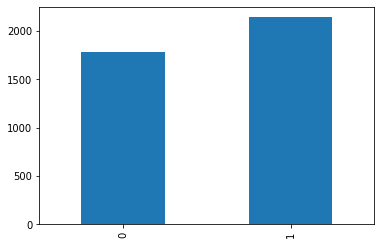

In [7]:
# Exploring counts of https string
train_labels[train_text.str.contains("https | http")]\
.value_counts().sort_index().plot.bar(x = "Target Value", y = "Number of Occurences")

This simple bar chart tells us that if a tweet contains the "https" or "http" string, it is slightly more likely that the tweet in question is a disaster related tweet. This seems useful, so we will keep the strings in there rather than filter them out.

# Text to Numeric Transformation

Now that our data has been cleaned, we'll need to transform it to a numeric representation. We do this because while words have meaning to us, a computer would struggle to understand sentences the same way that a human does. We'll be using the `Tokenizer` class from TensorFlow to perform this transformation. This process maps each unique word to a number in a vector, effectively storing the frequency of certain words in each tweet.

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Creating the tokenizer
tokenizer = Tokenizer(num_words = 10_000, oov_token = "<OOV>")
tokenizer.fit_on_texts(train_text)

# Creates sequences of word numeric representation
training_seqs = tokenizer.texts_to_sequences(train_text)

# Padding the sequences to all have the same length
training_seqs = pad_sequences(training_seqs, maxlen = 140)

testing_seqs = tokenizer.texts_to_sequences(test_text)
testing_seqs = pad_sequences(testing_seqs, maxlen = 140)

In [9]:
# Printing a sample of the new numeric representation for each tweet
print("Processed Tweet in numeric form")
print("---------------\n")
for i in range(5):
    print(training_seqs[i], "\n")

Processed Tweet in numeric form
---------------

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 4034  709   62 2563 4035   28] 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0

# Creating Callbacks

In TensorFlow, callbacks are used to allow the user to intervene during a model's training period. These may be used to check progress, edit processing flow to change the input data, or to set thresholds for when the model should stop training. We will be using a callback that we create to stop the model from training any further once it reaches 95% accuracy on the training data.

In [10]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("Accuracy") > 0.95:
            print("Accuracy >= 95%, training stopped.")
            self.model.stop_training = True
            
my_callback = CustomCallback()

In [11]:
# dynamically update learning rate based on epoch number
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch > 2:
        return 0.01
    else:
        return lr * 0.99
    
lr_scheduler = LearningRateScheduler(scheduler)

# Crafting the Neural Network

We will now be creating a neural network that takes the processed tweet and outputs a prediction of 1 if the tweet is about a real disaster, or 0 if the tweet does not pertain to a real disaster. 

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

input_dim = 10_000
input_length = 140

# Model architecture
model = Sequential([
    Embedding(input_dim = input_dim, output_dim = 64, input_length = input_length),
    Bidirectional(LSTM(150)),
    Dropout(0.4),
    Dense(512, activation = "relu"),
    Dropout(0.5),
    Dense(1, activation = "sigmoid")
])

model.compile(
    loss = "binary_crossentropy",
    optimizer = Adam(),
    metrics = ["Accuracy", "Precision", "Recall"]
)

model.summary()

2022-05-27 23:36:16.110300: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 64)           640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               258000    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               154112    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 1,052,625
Trainable params: 1,052,625
Non-trainable params: 0
______________________________________________

In [13]:
# Training the model
history = model.fit(
    np.array(training_seqs),
    np.array(train_labels),
    epochs = 100,
    batch_size = 128,
    callbacks = [my_callback, lr_scheduler],
    verbose = 1)

Epoch 1/100


2022-05-27 23:36:16.890651: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


60/60 [==============================] - 41s 596ms/step - loss: 0.6095 - Accuracy: 0.6619 - precision: 0.6649 - recall: 0.4295
Epoch 2/100
60/60 [==============================] - 36s 601ms/step - loss: 0.3564 - Accuracy: 0.8500 - precision: 0.8690 - recall: 0.7664
Epoch 3/100
60/60 [==============================] - 35s 586ms/step - loss: 0.2378 - Accuracy: 0.9073 - precision: 0.9226 - recall: 0.8560
Epoch 4/100
60/60 [==============================] - 36s 607ms/step - loss: 0.8603 - Accuracy: 0.7100 - precision: 0.6728 - recall: 0.6325
Epoch 5/100
60/60 [==============================] - 37s 612ms/step - loss: 0.3428 - Accuracy: 0.8642 - precision: 0.8676 - recall: 0.8071
Epoch 6/100
60/60 [==============================] - 35s 591ms/step - loss: 0.2065 - Accuracy: 0.9251 - precision: 0.9418 - recall: 0.8802
Epoch 7/100
60/60 [==============================] - 36s 598ms/step - loss: 0.1375 - Accuracy: 0.9489 - precision: 0.9569 - recall: 0.9227
Epoch 8/100
60/60 [====================

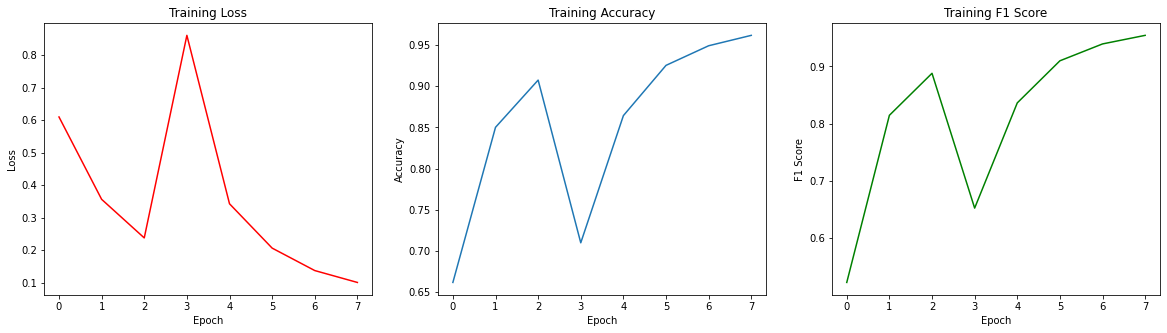

In [14]:
# Plotting the trianing history of the model
plt.rcParams["figure.figsize"] = (20, 5)
fig, axs = plt.subplots(1, 3)

axs[0].plot(history.history["loss"], color = "red")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")

axs[1].plot(history.history["Accuracy"])
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training Accuracy")

f1 = 2 * ((np.array(history.history["precision"])*np.array(history.history["recall"]))\
          /((np.array(history.history["precision"])+np.array(history.history["recall"]))))

axs[2].plot(f1, color = "green")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("F1 Score")
axs[2].set_title("Training F1 Score")

plt.show()

In [15]:
# Creating predictions for testing data
evaluation = model.predict(np.array(testing_seqs),
                          batch_size = 128,
                          verbose = 1)

submission_df = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
submission_df["target"] = np.int_(evaluation.round())
submission_df.head()

26/26 [==============================] - 5s 171ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [16]:
submission_df.to_csv("submission.csv", index = False)